# Data Analysis

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func, case, Column, Integer, String, Float, func, cast, DECIMAL, extract

# data
import pandas as pd
import numpy as np
import datetime as dt

# viz
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load variables with connection information to database
SQL_USERNAME = "postgres"
SQL_PASSWORD = "postgres"
SQL_IP = "localhost"
PORT = 5432
DATABASE = "crowdfunding_db"

In [3]:
# create connection using pre-defined variables
connection_string = f"postgresql+psycopg2://{SQL_USERNAME}:{SQL_PASSWORD}@{SQL_IP}:{PORT}/{DATABASE}"
engine = create_engine(connection_string)

In [4]:
# explore and understand the data

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within each table and its types
for table in tables:
    print(table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
        
    print()

contacts
contact_id INTEGER
first_name VARCHAR(25)
last_name VARCHAR(25)
email VARCHAR(50)
last_updated TIMESTAMP

campaign
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description VARCHAR(100)
goal DOUBLE PRECISION
pledged DOUBLE PRECISION
outcome VARCHAR(25)
backers_count INTEGER
country VARCHAR(5)
currency VARCHAR(5)
launched_date TIMESTAMP
end_date TIMESTAMP
category_id VARCHAR(10)
subcategory_id VARCHAR(10)
last_updated TIMESTAMP

category
category_id VARCHAR(10)
category VARCHAR(50)
last_updated TIMESTAMP

subcategory
subcategory_id VARCHAR(10)
subcategory VARCHAR(50)
last_updated TIMESTAMP



In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['campaign', 'subcategory', 'category', 'contacts']

In [7]:
# Save references to each table
campaign = Base.classes.campaign
subcategory = Base.classes.subcategory
contacts = Base.classes.contacts
category = Base.classes.category

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

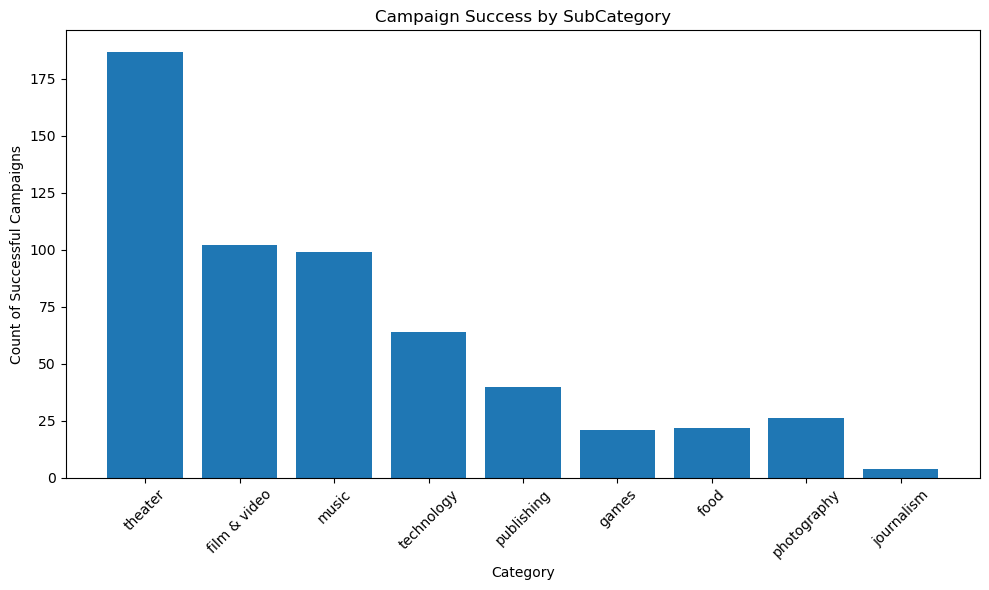

In [9]:
# Query using SQLAlchemy
category_success = session.query(
    campaign.category_id,
    func.sum(case((campaign.outcome == 'successful', 1), else_=0)).\
    label('successful_campaigns')).\
    group_by(campaign.category_id).\
    order_by(func.count(campaign.cf_id).\
    desc()).all()

# Convert query result to a DataFrame for visualization
df = pd.DataFrame(category_success, columns=['category_id', 'successful_campaigns'])

# Load the category names
category_data = session.query(category).all()

# Convert category_data to DataFrame
category_df = pd.DataFrame([(c.category_id, c.category) for c in category_data], columns=['category_id', 'category'])

# Merge the category names
df = df.merge(category_df, on='category_id', how='left')

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(df['category'], df['successful_campaigns'])
plt.xlabel('Category')
plt.ylabel('Count of Successful Campaigns')
plt.title('Campaign Success by SubCategory')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


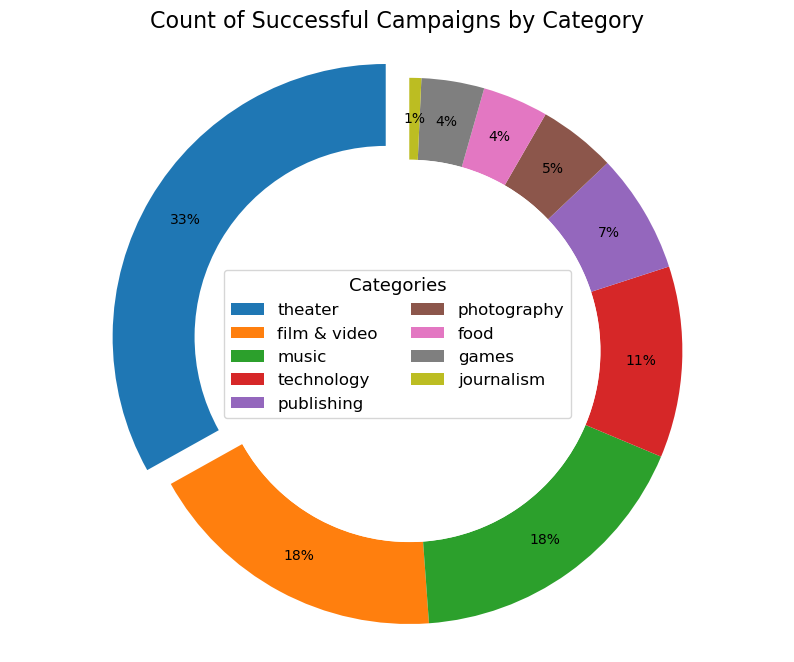

In [10]:
# Raw SQL query to gather data from Postgres
query = """
        SELECT COUNT(c.*) as success_count, cat.category as category
        FROM campaign c
        JOIN category cat ON cat.category_id = c.category_id
        WHERE c.outcome = 'successful'
        GROUP BY cat.category
        ORDER BY COUNT(c.*) DESC;
        """
# Save data to DataFrame
campaigns_by_outcome = pd.read_sql_query(query, engine) 

# Creating dataset
labels = campaigns_by_outcome['category']
sizes = campaigns_by_outcome['success_count']

# Creating explode data
explode = [0.1 if size == max(sizes) else 0 for size in sizes]

# Creating a pie chart
fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(sizes, pctdistance=0.85, autopct='%1.f%%', startangle=90, 
                                  explode=explode, wedgeprops=dict(width=0.3))

# Adding a circle at the center to transform it into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# Adding title
plt.title('Count of Successful Campaigns by Category', fontsize=16)

# Add Legend in the middle of the donut
plt.legend(wedges, labels, title="Categories", loc="center", fontsize=12, title_fontsize='13', ncol=2)

# Show the plot
plt.show()

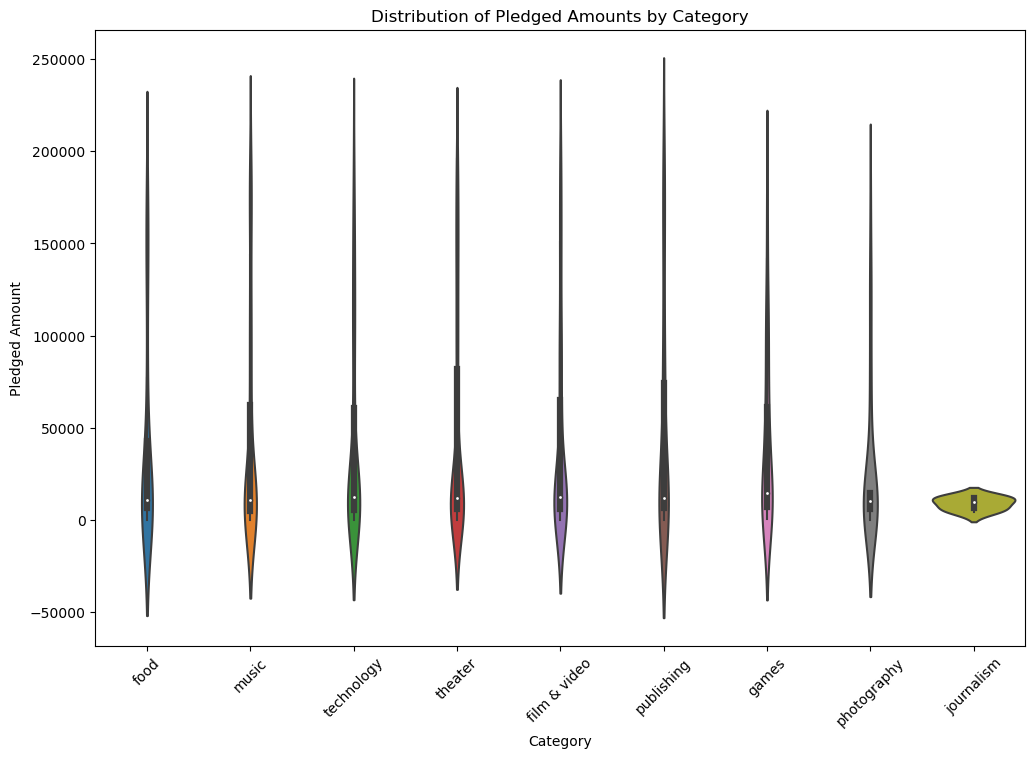

In [11]:
# Query the data using SQL to get the necessary columns
query = """
        SELECT c.pledged, cat.category
        FROM campaign c
        JOIN category cat ON c.category_id = cat.category_id
        """

df = pd.read_sql_query(query, engine)

# Create a violin plot using Seaborn
plt.figure(figsize=(12, 8))
sns.violinplot(x='category', y='pledged', data=df)
plt.title('Distribution of Pledged Amounts by Category')
plt.xlabel('Category')
plt.ylabel('Pledged Amount')
plt.xticks(rotation=45)
plt.show()

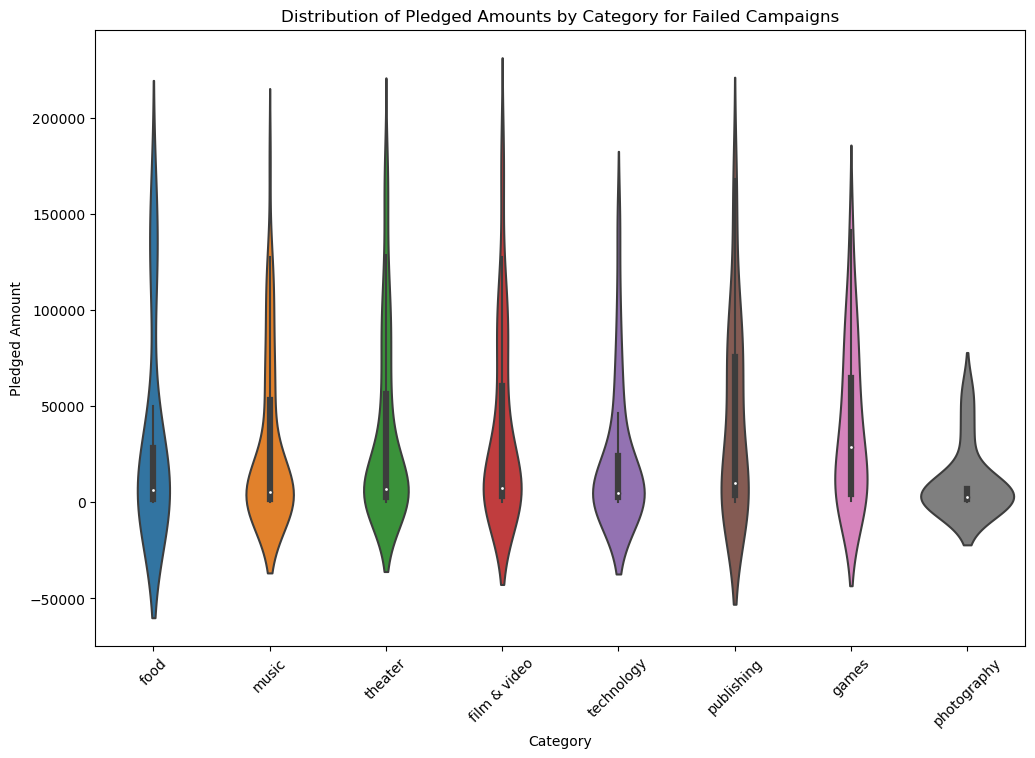

In [12]:
# Query the data using SQL to get the necessary columns
query = """
        SELECT c.pledged, cat.category
        FROM campaign c
        JOIN category cat ON c.category_id = cat.category_id
        WHERE c.outcome = 'failed';
        """

df = pd.read_sql_query(query, engine)

# Create a violin plot using Seaborn
plt.figure(figsize=(12, 8))
sns.violinplot(x='category', y='pledged', data=df)
plt.title('Distribution of Pledged Amounts by Category for Failed Campaigns')
plt.xlabel('Category')
plt.ylabel('Pledged Amount')
plt.xticks(rotation=45)
plt.show()

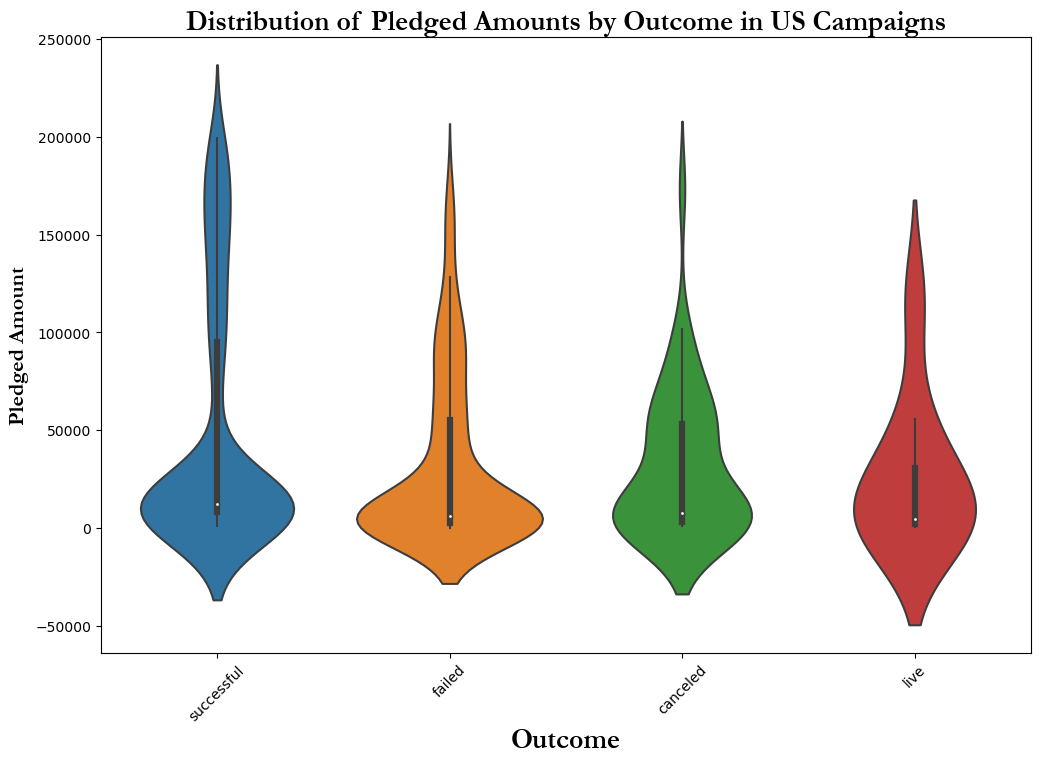

In [13]:
# Query the data using SQL to get the necessary columns
query = """
        SELECT c.pledged, c.outcome
        FROM campaign c
        WHERE c.country = 'US';
        """

df = pd.read_sql_query(query, engine)
# Create a violin plot using Seaborn
plt.figure(figsize=(12, 8))
sns.violinplot(x='outcome', y='pledged', data=df)
plt.title('Distribution of Pledged Amounts by Outcome in US Campaigns', fontdict={'size': 20, 'weight': 'bold', 'name': 'Garamond'})
plt.xlabel('Outcome', fontdict={'size': 20, 'weight': 'bold', 'name': 'Garamond'})
plt.ylabel('Pledged Amount', fontdict={'size': 16, 'weight': 'bold', 'name': 'Garamond'})
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

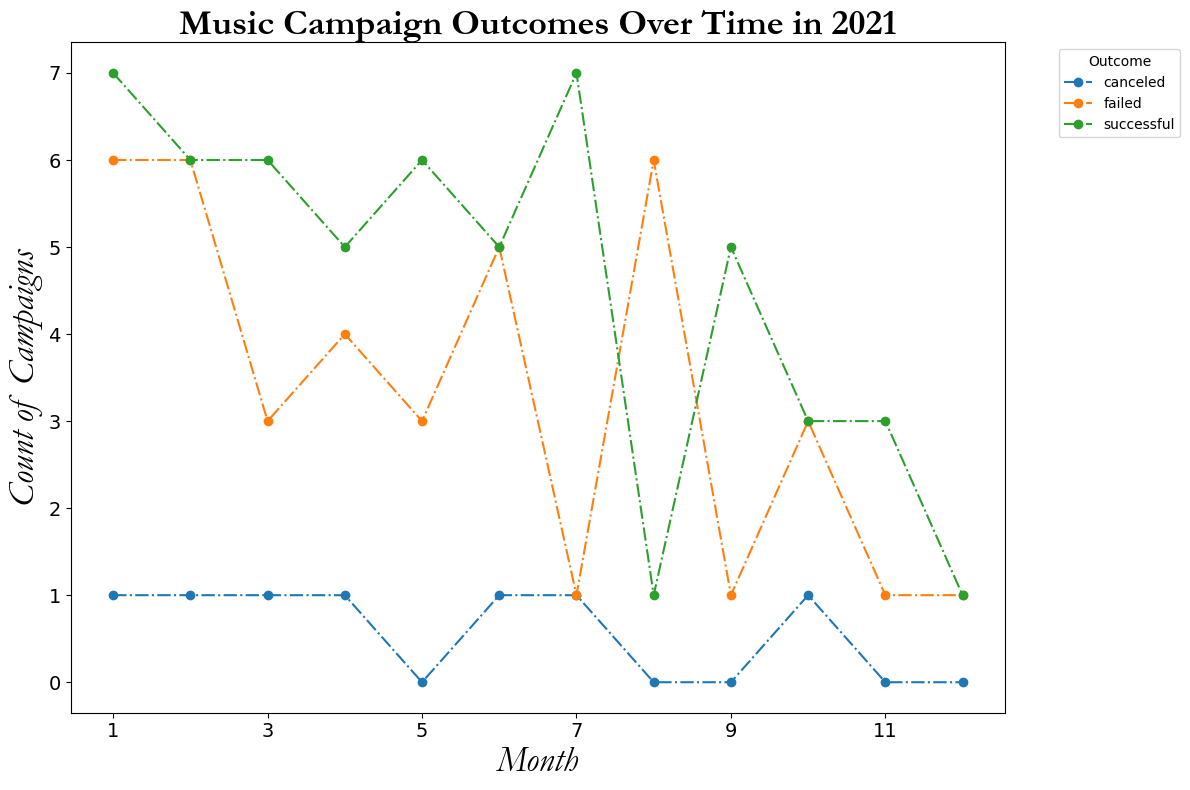

In [14]:
# Query to get campaign outcomes with launch date for the year 2021 and category of music
campaign_outcomes_query = session.query(
                            extract('month', campaign.launched_date).label('month'),
                            campaign.outcome,
                            func.count(campaign.cf_id).label('count')
                            ).\
                            join(category, campaign.category_id == category.category_id).\
                            filter(extract('year', campaign.launched_date) == 2021).\
                            filter(category.category == 'music').\
                            group_by(
                            extract('month', campaign.launched_date),
                            campaign.outcome
                            ).all()

# Convert query result to a DataFrame
campaign_outcomes_df = pd.DataFrame(campaign_outcomes_query, columns=['month', 'outcome', 'count'])

# Pivot the data to get months as index and outcomes as columns
pivot_df = campaign_outcomes_df.pivot(index='month', columns='outcome', values='count').fillna(0)

# Plot the line chart
plt.figure(figsize=(12, 8))
pivot_df.plot(kind='line', figsize=(12, 8), linestyle='-.', marker='o')
plt.title('Music Campaign Outcomes Over Time in 2021', fontdict={'size': 26, 'weight': 'bold', 'name': 'Garamond'})
plt.xlabel('Month', fontdict={'size': 26, 'weight': 'bold', 'name': 'Garamond', 'style': 'italic'})
plt.ylabel('Count of Campaigns', fontdict={'size': 26, 'weight': 'bold', 'name': 'Garamond', 'style': 'italic'})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [15]:
# Close Session
session.close()

In [16]:
# dispose of sql engine to close connection to database
engine.dispose()